# Dataset Class

In [74]:
import torch
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F

from torchvision import transforms, utils
from  Dataset.visualize_keypoint import *
from src.dataload import *
import warnings
warnings.filterwarnings("ignore")

In [75]:
# cow sheep horse cat dog
labels = ['dog', 'cat', 'sheep', 'horse', 'cow']

class AnimalPoseDataset(Dataset):
    def __init__ (self, json_file, root_dir, transform=None):
        self.keypoints_frame = json.load(open(json_file))
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.keypoints_frame["annotations"])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        anno_dict = self.keypoints_frame
        img_id = anno_dict["annotations"][idx]["image_id"]
        image_map = anno_dict["images"]
        annotations = anno_dict["annotations"]

        imagename = image_map[str(annotations[idx]["image_id"])]
        bbox = annotations[idx]["bbox"]
        keypoints = annotations[idx]["keypoints"]
        label = labels[annotations[idx]["category_id"]-1]
        image_path = os.path.join(self.root_dir, imagename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample = {'image_id': img_id, 'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def draw(self, sample):
        image = sample['image']
        bbox = sample['bbox']
        xmin, ymin, xmax, ymax = bbox 
        image = draw_bbox(image, xmin, ymin, xmax, ymax, random_color())
        image = draw_keypoint(image, sample['keypoints'])
        return image


# Adversarial SDA transform

In [80]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

  return result

class Rescale (object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__ (self, sample):
        img_id, image, keypoints, bbox = sample['image_id'],sample['image'], sample['keypoints'], sample['bbox']
        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        # scale the image
        img = transform.resize(image, (new_h, new_w))
        # scale the keypoints
        scaled_keypoints = []
        for kp in keypoints:
            new_x = int(kp[0] * new_w / w)
            new_y = int(kp[1] * new_h / h)
            scaled_keypoints.append([new_x, new_y, kp[2]])
        # scale the bbox
        xmin, ymin, xmax, ymax = bbox
        xmin = int(xmin * new_w / w)
        xmax = int(xmax * new_w / w)
        ymin = int(ymin * new_h / h)
        ymax = int(ymax * new_h / h)
        bbox = [xmin, ymin, xmax, ymax]
        

        return {'image_id':img_id, 'image': img, 'keypoints': scaled_keypoints, 'bbox':bbox, 'label':sample['label']}
        
class SDA(object):
    
    def __init__(self, nb_bodyparts, tolerance=20):
        # number of body parts to add to the image
        self.nb_bodyparts = nb_bodyparts
        self.bodypart_pool = []
        self.tolerance=tolerance

    def __call__(self, sample):
        img_id, image, keypoints, bbox = sample['image_id'], sample['image'], sample['keypoints'], sample['bbox']
        image, keypoints, bodyparts = self.crop_bodypart(image, keypoints)
        self.bodypart_pool.extend(bodyparts)
        
        # add the body parts to the image
        for i in range(self.nb_bodyparts):
            image = self.add_bodyparts(image)
            
        return {'image_id':img_id, 'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':sample['label']}

    def crop_bodypart(self, image, keypoints):
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        draw_keypoint(mask, keypoints)
        # find the contours in the mask
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # crop the different body parts and store them 
        bodyparts = []
        for i in range(len(contours)):
            x,y,w,h = cv2.boundingRect(contours[i])
            bodyparts.append(image[y-self.tolerance:y+h+self.tolerance, x-self.tolerance:x+w+self.tolerance])
        # return the image with the body parts and the keypoints
        return image, keypoints, bodyparts
    
    def add_bodyparts(self, image):        
        # randomly select a body part
        bodypart = random.choice(self.bodypart_pool)
        # randomly select an angle
        #angle = random.randint(0, 360)        
        # rotate the body part
        #bodypart = rotate_image(bodypart, angle)
        h,w,_ = bodypart.shape

        # randomly select a position for the body part
        x = random.randint(0, image.shape[1] - w)
        y = random.randint(0, image.shape[0] - h)
        
        image[y:y+h, x:x+w] = cv2.addWeighted(image[y:y+h, x:x+w], 0, bodypart, 1, 0)
        return image


    def show_bodyparts(self):     
        for i in range(len(self.bodypart_pool)):
            plt.imshow(self.bodypart_pool[i])
            plt.show()



# Dataloader


[51, 104, 858, 835]
0 torch.Size([10, 1024, 1024, 3]) ['horse', 'cat', 'horse', 'dog', 'sheep', 'horse', 'horse', 'cat', 'cat', 'cow']
[tensor([  3, 349, 270, 585,  48,   2, 219,   2,   2, 923]), tensor([120, 325,  32, 408, 447,  73,  58, 289, 312, 419]), tensor([ 937,  731,  899, 1024,  166,  918,  854,  583, 1024, 1024]), tensor([1024,  645, 1024, 1020,  607, 1024, 1024, 1024, 1024,  696])]
1 torch.Size([10, 1024, 1024, 3]) ['sheep', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'horse']
[tensor([206, 155, 139,  17, 663, 151, 380, 100, 679, 478]), tensor([ 84,  96,   2,  52, 155, 196, 234,  55, 507, 315]), tensor([ 804,  496, 1024,  925, 1021,  755,  509,  501,  845,  822]), tensor([1002,  688, 1024,  866,  578,  974,  557,  941,  614,  978])]
[tensor([206, 155, 139,  17, 663, 151, 380, 100, 679, 478]), tensor([ 84,  96,   2,  52, 155, 196, 234,  55, 507, 315]), tensor([ 804,  496, 1024,  925, 1021,  755,  509,  501,  845,  822]), tensor([1002,  688, 1024,  866,  578,  974,

<Figure size 640x480 with 0 Axes>

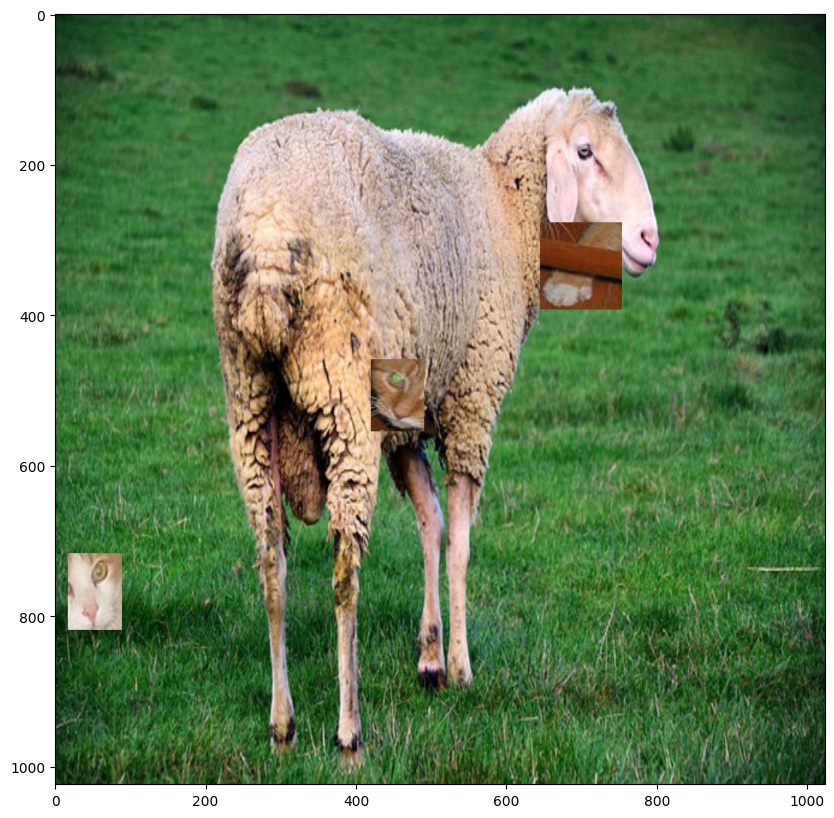

In [99]:
dataset = AnimalPoseDataset(json_file='Dataset/keypoints.json', 
                            root_dir='Dataset/images/',
                            transform=transforms.Compose([
                                                        Rescale((1024,1024)),
                                                        SDA(nb_bodyparts=3, tolerance=30)]))


dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

test = dataset.__getitem__(1)
print(test['bbox'])
for i_batch, sample_batched in enumerate(dataloader):
    
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])

    if i_batch == 1:
        # show the image with the keypoints
        plt.figure()
        # show image with BGR encoding
        #plt.imshow(sample_batched['image'][0].numpy())
        # increase the size of the figure
        plt.figure(figsize=(10,10))
        # pick a random sample from the batch and show it with it's keypoints

        sample = dataset.__getitem__(random.randint(0, len(dataset)))
        
        plt.imshow(sample['image'])
        print(sample['bbox'])
        plt.show()        
        break



    train_features, train labels 


